In [1]:
import sys
sys.path.append('/home/wenjie/learningSimulate/koopman/koopman')
import os


import os
import torch
import torch_geometric
from koopman.config import data_dir,model_dir
from koopman.water_preprocessing import compute_velocities
from random import shuffle
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
from torch_cluster.radius import radius_graph
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops
import matplotlib.pyplot as plt



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import torch
from torch_geometric.data import Batch
from torch_geometric_temporal.data.discrete import DynamicGraphDiscreteSignal as DGDS
from torch_cluster.radius import radius_graph


def batch_of_traj_graphs(batch_of_traj_dicts,r):
    '''Create a list of DGDS iterators for different trajectories.
    
    Args:
        batch_of_traj_dicts: a list of dicts with keys pos and vel.
                  pos: np.array of positions (shape = (traj_len-1,num_particles,state_dim))
                  vel: np.array of velocities (shape = (traj_len-1,num_particles,state_dim))
        r: float, connectivity radius, for each time slice and trajectory, edges between node_i and node_j are included iff dist(node_i,node_j) < r. 
        
    Returns:
        dgds_list: a list of DGDS iterators, one for each trajectory.
    '''
    
    dgds_list = []
    for traj in batch_of_traj_dicts:
        node_feats = [np.concatenate([traj['pos'][i],traj['vel'][i]],axis = 1) for i in range(len(traj['pos']))]
        node_feats_trunc, targets = node_feats[:-1],traj['pos'][1:] # stagger features to create koopman targets
        edge_inds=[radius_graph(torch.tensor(traj['pos'][i]), r = r,loop = True).numpy() for i in range(len(traj['pos'])-1)] # include edges between nodes in same local neighbor
        edge_weights = [np.array([np.linalg.norm(n[edg[0]][0:2]-n[edg[1]][0:2]) for edg in e.T]) for n,e in zip(node_feats_trunc,edge_inds)] # edge weights are distances between nodes
        dgds = DGDS(edge_indices = edge_inds,features = node_feats_trunc,edge_weights = edge_weights, targets = targets)
        dgds_list.append(dgds)
    
    return dgds_list 

class TrajectoryBatch:
    '''
    Iterator for a batch of trajectories.
    '''
    
    def __init__(self,dgds_list, time_steps):
        '''
        Args:
            dgds_list: a list of DGDS objects, each corresponding to a different trajectory.
            time_steps: int, number of time step to iterate through.
        '''
        self.iterator = [enumerate(dgds) for dgds in dgds_list]
        self.time_steps = time_steps
        self.counter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        
        if self.counter < self.time_steps:
            time_slice = [next(it)[1] for it in self.iterator]
            time_slice = Batch().from_data_list(time_slice)
            self.counter += 1
            return time_slice

        raise StopIteration

In [10]:
C,dt = 3,2.5
N_train,N_val,N_test = 1,1,1 # subset data

directory = str(data_dir)+'/WaterDropSample'
train_file,val_file,test_file = 'train.npz','valid.npz','test.npz'
os.chdir(directory)
trajs_train,trajs_val,trajs_test = np.load(train_file),np.load(val_file),np.load(test_file)
train_dicts, val_dicts, test_dicts= compute_velocities(trajs_train,dt = dt,C=C),compute_velocities(trajs_val,dt = dt,C=C),compute_velocities(trajs_test,dt = dt,C=C)

train_sub,val_sub,test_sub = train_dicts[0:N_train],val_dicts[0:N_val],test_dicts[0:N_test]

# convert data to graphical representations
r,time_steps = 0.015,40
train_gtrajs,val_gtrajs,test_gtrajs = batch_of_traj_graphs(train_sub,r = r),batch_of_traj_graphs(val_sub,r = r),batch_of_traj_graphs(test_sub,r = r)

In [11]:
#model define
class EdgeModel(torch.nn.Module):
    def __init__(self, init_node_dim, init_edge_dim, hidden_dim, final_dim):
        super(EdgeModel, self).__init__()
        self.edge_mlp = torch.nn.Sequential(torch.nn.Linear(init_node_dim*2+init_edge_dim, hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim, final_dim))
        
    def forward(self, src, dest, edge_attr, u=None, batch=None):
        
        out = torch.cat([src, dest, edge_attr],1)
        
        return self.edge_mlp(out)
    
    
class NodeModel(torch.nn.Module):
    def __init__(self, init_node_dim, hidden_dim, final_dim):
        super(NodeModel, self).__init__()
        self.node_mlp = torch.nn.Sequential(torch.nn.Linear(init_node_dim, hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim, final_dim))
        
        
    def forward(self, x, edge_index, edge_attr, u=None, batch=None):
        return self.node_mlp(x)
        
        
    
def build_Encoder(init_node_dim,init_edge_dim, hidden_dim, final_dim):
    return torch_geometric.nn.MetaLayer(
        edge_model=EdgeModel(init_node_dim, init_edge_dim, hidden_dim, final_dim),
        node_model=NodeModel(init_node_dim, hidden_dim, final_dim),
    )



import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, ReLU
from torch_scatter import scatter

from torch_geometric.nn import GENConv, DeepGCNLayer
from torch_geometric.data import RandomNodeSampler

class Processor(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(Processor, self).__init__()
        
        self.layers = torch.nn.ModuleList()
        
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = ReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,
                                 ckpt_grad=i % 3)
            self.layers.append(layer)

        
    def forward(self, x, edge_index, edge_attr):

        x = self.layers[0].conv(x, edge_index, edge_attr)

        for layer in self.layers[1:]:
            x = layer(x, edge_index, edge_attr)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.1, training=self.training)

        return x
        
        
class Decoder(torch.nn.Module):
    def __init__(self, hidden_channels, final_channels):
        super(Decoder, self).__init__()
        
        self.node_mlp = torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_channels, final_channels))
        
    def forward(self, x):
        return self.node_mlp(x)
    
    
class Encoder_Processor_Decoder(torch.nn.Module):
    def __init__(self, init_node_dim, init_edge_dim, hidden_dim, num_layers, final_dim):
        super(Encoder_Processor_Decoder, self).__init__()
        self.encoder = build_Encoder(init_node_dim, init_edge_dim, hidden_dim, hidden_dim)
        self.processor = Processor(hidden_dim, num_layers)
        self.decoder = Decoder(hidden_dim, final_dim)
        
    def forward(self, x, edge_index, edge_attr):
        x, new_edge_attr, _ = self.encoder(x, edge_index, edge_attr)
        x = self.processor(x, edge_index, new_edge_attr)
        x = self.decoder(x)
        
        return x
    

        
        
        



In [121]:
#build model

init_node_dim, init_edge_dim, hidden_dim, num_layers, final_dim = 8, 1, 128, 5, 2

model = Encoder_Processor_Decoder(init_node_dim, init_edge_dim, hidden_dim, num_layers, final_dim)

In [122]:
model = model.to(device)

In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma = 0.995)

L = torch.nn.MSELoss()
loss_reg= 1
max_norm = 0.01


In [124]:
epochs, bs, Sp = 3000, 1, 10
train_history = []

for ep in range(epochs):
    shuffle(train_gtrajs)
    ep_total_loss, val_total_loss = 0,0
    time_steps = min([40, ep + 2])
    
    for b in range(int(len(train_gtrajs)/bs)):
        start_ind, end_ind = int(b*bs), min(int((b+1)*bs), len(train_gtrajs))
        traj_batch = train_gtrajs[start_ind:end_ind]
        
        for t, time_slice in enumerate(TrajectoryBatch(traj_batch, time_steps = time_steps)):
            optimizer.zero_grad()
            loss = 0
            time_slice.to(device)
            
            x = model(time_slice.x, time_slice.edge_index,time_slice.edge_attr.unsqueeze(dim=0).t())
            y_hat = time_slice.x[:,0:2]+dt*x
            
            mse_loss = L(time_slice.y, y_hat)
            
            ep_total_loss += mse_loss
            
        ep_total_loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = max_norm)
        
        optimizer.step()

    if (ep+1)%1 == 0:
        
        print('Epoch {:d}: Loss = {}'.format(ep+1, ep_total_loss))
    
    train_history.append(ep_total_loss)
        
        

            
    


<ipython-input-124-f3e8b6515ce6>:26: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = max_norm)


Epoch 1: Loss = 0.12721219658851624
Epoch 2: Loss = 2.8087120056152344
Epoch 3: Loss = 0.7347193956375122
Epoch 4: Loss = 0.2493029534816742
Epoch 5: Loss = 0.21173825860023499
Epoch 6: Loss = 0.168402761220932
Epoch 7: Loss = 0.07328973710536957
Epoch 8: Loss = 0.12802909314632416
Epoch 9: Loss = 0.1421244740486145
Epoch 10: Loss = 0.07385696470737457
Epoch 11: Loss = 0.08738523721694946
Epoch 12: Loss = 0.1230461448431015
Epoch 13: Loss = 0.08330326527357101
Epoch 14: Loss = 0.05519348382949829
Epoch 15: Loss = 0.08149974793195724
Epoch 16: Loss = 0.06093311682343483
Epoch 17: Loss = 0.05349098518490791
Epoch 18: Loss = 0.05863519757986069
Epoch 19: Loss = 0.052666861563920975
Epoch 20: Loss = 0.03866855427622795
Epoch 21: Loss = 0.036441221833229065
Epoch 22: Loss = 0.04204364866018295
Epoch 23: Loss = 0.04010292887687683
Epoch 24: Loss = 0.02864505909383297
Epoch 25: Loss = 0.059628840535879135
Epoch 26: Loss = 0.048191413283348083
Epoch 27: Loss = 0.032996296882629395
Epoch 28: Lo

Epoch 215: Loss = 0.0006055488483980298
Epoch 216: Loss = 0.002203582553192973
Epoch 217: Loss = 0.0013734715757891536
Epoch 218: Loss = 0.0020954797510057688
Epoch 219: Loss = 0.001979528460651636
Epoch 220: Loss = 0.0018788868328556418
Epoch 221: Loss = 0.0008169438224285841
Epoch 222: Loss = 0.0027128634974360466
Epoch 223: Loss = 0.002309097908437252
Epoch 224: Loss = 0.0009819234255701303
Epoch 225: Loss = 0.0005317314062267542
Epoch 226: Loss = 0.004468635655939579
Epoch 227: Loss = 0.0029532373882830143
Epoch 228: Loss = 0.0011550411581993103
Epoch 229: Loss = 0.0011275261640548706
Epoch 230: Loss = 0.0026250644586980343
Epoch 231: Loss = 0.0014309637481346726
Epoch 232: Loss = 0.0024985456839203835
Epoch 233: Loss = 0.0027773252222687006
Epoch 234: Loss = 0.00048025790601968765
Epoch 235: Loss = 0.0008840546361170709
Epoch 236: Loss = 0.0005765914102084935
Epoch 237: Loss = 0.0015219590859487653
Epoch 238: Loss = 0.0008040382526814938
Epoch 239: Loss = 0.002078362973406911
Epoc

Epoch 421: Loss = 0.0006835677777417004
Epoch 422: Loss = 0.0005537294782698154
Epoch 423: Loss = 0.0004927422851324081
Epoch 424: Loss = 0.0005804126849398017
Epoch 425: Loss = 0.0004205371660646051
Epoch 426: Loss = 0.000674281211104244
Epoch 427: Loss = 0.0006560773472301662
Epoch 428: Loss = 0.00022913439897820354
Epoch 429: Loss = 0.00014691072283312678
Epoch 430: Loss = 0.000840594875626266
Epoch 431: Loss = 0.0006756509537808597
Epoch 432: Loss = 0.00032987649319693446
Epoch 433: Loss = 0.0003021873126272112
Epoch 434: Loss = 0.0005318360053934157
Epoch 435: Loss = 0.0003155593294650316
Epoch 436: Loss = 0.0006649072165600955
Epoch 437: Loss = 0.0006003105663694441
Epoch 438: Loss = 0.0004790373204741627
Epoch 439: Loss = 0.0001509603316662833
Epoch 440: Loss = 0.001332571031525731
Epoch 441: Loss = 0.0010745119070634246
Epoch 442: Loss = 0.0002678903110790998
Epoch 443: Loss = 0.0003261590318288654
Epoch 444: Loss = 0.0004327428468968719
Epoch 445: Loss = 0.00020118974498473108

Epoch 625: Loss = 0.0002070855989586562
Epoch 626: Loss = 9.568579844199121e-05
Epoch 627: Loss = 6.596396997338161e-05
Epoch 628: Loss = 0.0002623286854941398
Epoch 629: Loss = 0.00021754566114395857
Epoch 630: Loss = 9.219640924129635e-05
Epoch 631: Loss = 8.653227268951014e-05
Epoch 632: Loss = 0.00018940848531201482
Epoch 633: Loss = 0.00010749586363090202
Epoch 634: Loss = 0.00021653837757185102
Epoch 635: Loss = 0.00019889035320375115
Epoch 636: Loss = 0.00011189209908479825
Epoch 637: Loss = 7.927497063064948e-05
Epoch 638: Loss = 0.00023985600273590535
Epoch 639: Loss = 0.00011446417192928493
Epoch 640: Loss = 0.00038880592910572886
Epoch 641: Loss = 0.0003339664835948497
Epoch 642: Loss = 0.00010687715985113755
Epoch 643: Loss = 0.00013091479195281863
Epoch 644: Loss = 0.00012117595179006457
Epoch 645: Loss = 5.46222654520534e-05
Epoch 646: Loss = 0.0005093176732771099
Epoch 647: Loss = 0.0004210152546875179
Epoch 648: Loss = 6.0819358623120934e-05
Epoch 649: Loss = 0.00015289

Epoch 828: Loss = 4.3311149056535214e-05
Epoch 829: Loss = 1.4986020687501878e-05
Epoch 830: Loss = 5.478928505908698e-05
Epoch 831: Loss = 2.054458309430629e-05
Epoch 832: Loss = 0.0001056148685165681
Epoch 833: Loss = 9.137734741671011e-05
Epoch 834: Loss = 1.8424634617986158e-05
Epoch 835: Loss = 0.00013515554019249976
Epoch 836: Loss = 6.630196003243327e-05
Epoch 837: Loss = 0.0001373689592583105
Epoch 838: Loss = 0.00015958110452629626
Epoch 839: Loss = 4.719133357866667e-05
Epoch 840: Loss = 6.814085645601153e-05
Epoch 841: Loss = 7.876316522015259e-05
Epoch 842: Loss = 3.0181088732206263e-05
Epoch 843: Loss = 0.00020100032270420343
Epoch 844: Loss = 0.00018496271513868123
Epoch 845: Loss = 2.1533824110520072e-05
Epoch 846: Loss = 2.2648460799246095e-05
Epoch 847: Loss = 5.669757229043171e-05
Epoch 848: Loss = 3.2786567317089066e-05
Epoch 849: Loss = 4.6143111831042916e-05
Epoch 850: Loss = 4.066904148203321e-05
Epoch 851: Loss = 3.419129643589258e-05
Epoch 852: Loss = 2.83138942

Epoch 1031: Loss = 0.0001659699628362432
Epoch 1032: Loss = 0.0002168139471905306
Epoch 1033: Loss = 7.003005157457665e-05
Epoch 1034: Loss = 0.0001700734719634056
Epoch 1035: Loss = 0.0001853436988312751
Epoch 1036: Loss = 2.709170257730875e-05
Epoch 1037: Loss = 0.00026971340412274003
Epoch 1038: Loss = 0.0003265721898060292
Epoch 1039: Loss = 8.75808036653325e-05
Epoch 1040: Loss = 0.00012156616139691323
Epoch 1041: Loss = 0.0001908955309772864
Epoch 1042: Loss = 0.00010846447548829019
Epoch 1043: Loss = 5.544650412048213e-05
Epoch 1044: Loss = 0.00011272662231931463
Epoch 1045: Loss = 2.7241503630648367e-05
Epoch 1046: Loss = 0.0002762801887001842
Epoch 1047: Loss = 0.0003747872542589903
Epoch 1048: Loss = 9.181874338537455e-05
Epoch 1049: Loss = 0.0001500846992712468
Epoch 1050: Loss = 0.0002737953618634492
Epoch 1051: Loss = 0.00012438900012057275
Epoch 1052: Loss = 9.061342279892415e-05
Epoch 1053: Loss = 9.074293484445661e-05
Epoch 1054: Loss = 7.64646174502559e-05
Epoch 1055: 

Epoch 1230: Loss = 1.7735246728989296e-05
Epoch 1231: Loss = 5.458579835249111e-05
Epoch 1232: Loss = 5.3017236496089026e-05
Epoch 1233: Loss = 1.558107942400966e-05
Epoch 1234: Loss = 1.3836268408340402e-05
Epoch 1235: Loss = 6.022433808539063e-05
Epoch 1236: Loss = 5.026729922974482e-05
Epoch 1237: Loss = 1.9234112187405117e-05
Epoch 1238: Loss = 2.1286994524416514e-05
Epoch 1239: Loss = 2.909446629928425e-05
Epoch 1240: Loss = 1.7370146451867186e-05
Epoch 1241: Loss = 5.096478707855567e-05
Epoch 1242: Loss = 4.537516724667512e-05
Epoch 1243: Loss = 2.3226599296322092e-05
Epoch 1244: Loss = 2.559649510658346e-05
Epoch 1245: Loss = 2.8803628083551303e-05
Epoch 1246: Loss = 1.8694101527216844e-05
Epoch 1247: Loss = 5.439379674498923e-05
Epoch 1248: Loss = 5.076203524367884e-05
Epoch 1249: Loss = 1.5924897525110282e-05
Epoch 1250: Loss = 1.4923903108865488e-05
Epoch 1251: Loss = 5.017137300455943e-05
Epoch 1252: Loss = 3.9943333831615746e-05
Epoch 1253: Loss = 2.401231358817313e-05
Epoc

Epoch 1428: Loss = 3.098452361882664e-05
Epoch 1429: Loss = 2.7315265469951555e-05
Epoch 1430: Loss = 2.2638359951088205e-05
Epoch 1431: Loss = 2.9886885386076756e-05
Epoch 1432: Loss = 2.3556349333375692e-05
Epoch 1433: Loss = 2.9558888854808174e-05
Epoch 1434: Loss = 2.7262956791673787e-05
Epoch 1435: Loss = 2.4393704734393395e-05
Epoch 1436: Loss = 2.19168359762989e-05
Epoch 1437: Loss = 2.958780351036694e-05
Epoch 1438: Loss = 2.6426449039718136e-05
Epoch 1439: Loss = 2.5750337954377756e-05
Epoch 1440: Loss = 2.16767057281686e-05
Epoch 1441: Loss = 2.956160096800886e-05
Epoch 1442: Loss = 2.5328501578769647e-05
Epoch 1443: Loss = 2.6648487619240768e-05
Epoch 1444: Loss = 2.5260043912567198e-05
Epoch 1445: Loss = 2.2503381842398085e-05
Epoch 1446: Loss = 1.900309325719718e-05
Epoch 1447: Loss = 3.326102887513116e-05
Epoch 1448: Loss = 2.9249797080410644e-05
Epoch 1449: Loss = 2.1304696929291822e-05
Epoch 1450: Loss = 1.962927490239963e-05
Epoch 1451: Loss = 2.6904548576567322e-05
Ep

Epoch 1626: Loss = 1.494059688411653e-05
Epoch 1627: Loss = 3.970280522480607e-05
Epoch 1628: Loss = 3.5913093597628176e-05
Epoch 1629: Loss = 1.5879541024332866e-05
Epoch 1630: Loss = 1.476970919611631e-05
Epoch 1631: Loss = 3.521053440636024e-05
Epoch 1632: Loss = 2.7640109692583792e-05
Epoch 1633: Loss = 2.310766649316065e-05
Epoch 1634: Loss = 2.2567486666957848e-05
Epoch 1635: Loss = 2.3020425942377187e-05
Epoch 1636: Loss = 1.910345054056961e-05
Epoch 1637: Loss = 3.186956018907949e-05
Epoch 1638: Loss = 2.8336075047263876e-05
Epoch 1639: Loss = 2.0275572751415893e-05
Epoch 1640: Loss = 1.9387027350603603e-05
Epoch 1641: Loss = 2.7471436624182388e-05
Epoch 1642: Loss = 2.2719896151102148e-05
Epoch 1643: Loss = 2.683163620531559e-05
Epoch 1644: Loss = 2.548388329159934e-05
Epoch 1645: Loss = 2.0892992324661463e-05
Epoch 1646: Loss = 1.7749429389368743e-05
Epoch 1647: Loss = 3.346271114423871e-05
Epoch 1648: Loss = 3.131873017991893e-05
Epoch 1649: Loss = 1.7212892998941243e-05
Epo

Epoch 1824: Loss = 1.6644717106828466e-05
Epoch 1825: Loss = 3.606883910833858e-05
Epoch 1826: Loss = 3.618994742282666e-05
Epoch 1827: Loss = 1.3889937690692022e-05
Epoch 1828: Loss = 1.6068383047240786e-05
Epoch 1829: Loss = 1.9759920178330503e-05
Epoch 1830: Loss = 1.3457005479722284e-05
Epoch 1831: Loss = 2.6568699468043633e-05
Epoch 1832: Loss = 1.9084271116298623e-05
Epoch 1833: Loss = 2.60482029261766e-05
Epoch 1834: Loss = 2.5437127987970598e-05
Epoch 1835: Loss = 1.8041895600617863e-05
Epoch 1836: Loss = 2.1605172150884755e-05
Epoch 1837: Loss = 1.671626523602754e-05
Epoch 1838: Loss = 2.5380337319802493e-05
Epoch 1839: Loss = 2.09197896765545e-05
Epoch 1840: Loss = 2.1256999389152043e-05
Epoch 1841: Loss = 2.0920468159602024e-05
Epoch 1842: Loss = 1.877195609267801e-05
Epoch 1843: Loss = 1.6402678738813847e-05
Epoch 1844: Loss = 2.1305744667188264e-05
Epoch 1845: Loss = 1.8227448890684173e-05
Epoch 1846: Loss = 2.155048423446715e-05
Epoch 1847: Loss = 1.902634721773211e-05
Ep

Epoch 2022: Loss = 4.205412187729962e-05
Epoch 2023: Loss = 1.826110565161798e-05
Epoch 2024: Loss = 3.113035563728772e-05
Epoch 2025: Loss = 5.273691567708738e-05
Epoch 2026: Loss = 2.4531093004043214e-05
Epoch 2027: Loss = 2.2773441742174327e-05
Epoch 2028: Loss = 3.8557300285901874e-05
Epoch 2029: Loss = 1.6652596968924627e-05
Epoch 2030: Loss = 3.333882341394201e-05
Epoch 2031: Loss = 5.525723463506438e-05
Epoch 2032: Loss = 2.533597762521822e-05
Epoch 2033: Loss = 2.2077467292547226e-05
Epoch 2034: Loss = 3.6886547604808584e-05
Epoch 2035: Loss = 1.629331563890446e-05
Epoch 2036: Loss = 3.447676499490626e-05
Epoch 2037: Loss = 5.6148455769289285e-05
Epoch 2038: Loss = 2.6248333597322926e-05
Epoch 2039: Loss = 2.098915501846932e-05
Epoch 2040: Loss = 3.46733104379382e-05
Epoch 2041: Loss = 1.5509460354223847e-05
Epoch 2042: Loss = 3.5069126170128584e-05
Epoch 2043: Loss = 5.7021145039470866e-05
Epoch 2044: Loss = 2.7044086891692132e-05
Epoch 2045: Loss = 2.087883149215486e-05
Epoch

Epoch 2220: Loss = 4.1755960410228e-05
Epoch 2221: Loss = 2.054749165836256e-05
Epoch 2222: Loss = 2.0145422240602784e-05
Epoch 2223: Loss = 3.169944102410227e-05
Epoch 2224: Loss = 1.5313327821786515e-05
Epoch 2225: Loss = 2.763856537058018e-05
Epoch 2226: Loss = 4.3635194742819294e-05
Epoch 2227: Loss = 2.1482741431100294e-05
Epoch 2228: Loss = 1.9494134903652593e-05
Epoch 2229: Loss = 3.1572082662023604e-05
Epoch 2230: Loss = 1.538999094918836e-05
Epoch 2231: Loss = 2.656287506397348e-05
Epoch 2232: Loss = 4.158712908974849e-05
Epoch 2233: Loss = 2.0127668904024176e-05
Epoch 2234: Loss = 2.0952720660716295e-05
Epoch 2235: Loss = 3.355511580593884e-05
Epoch 2236: Loss = 1.6653144484735094e-05
Epoch 2237: Loss = 2.4483400920871645e-05
Epoch 2238: Loss = 3.8830847188364714e-05
Epoch 2239: Loss = 1.839834476413671e-05
Epoch 2240: Loss = 2.212653089372907e-05
Epoch 2241: Loss = 3.5859156923834234e-05
Epoch 2242: Loss = 1.7615615433896892e-05
Epoch 2243: Loss = 2.3345639419858344e-05
Epoc

Epoch 2418: Loss = 1.399879784003133e-05
Epoch 2419: Loss = 1.1171775440743659e-05
Epoch 2420: Loss = 2.200428571086377e-05
Epoch 2421: Loss = 2.2220508981263265e-05
Epoch 2422: Loss = 1.0566125638433732e-05
Epoch 2423: Loss = 1.2534985216916539e-05
Epoch 2424: Loss = 1.694432648946531e-05
Epoch 2425: Loss = 1.1309767614875454e-05
Epoch 2426: Loss = 3.248866050853394e-05
Epoch 2427: Loss = 3.258853030274622e-05
Epoch 2428: Loss = 1.4458171790465713e-05
Epoch 2429: Loss = 2.1948773792246357e-05
Epoch 2430: Loss = 2.4140883397194557e-05
Epoch 2431: Loss = 1.4716951227455866e-05
Epoch 2432: Loss = 2.5635874408180825e-05
Epoch 2433: Loss = 2.9988350433995947e-05
Epoch 2434: Loss = 1.1071102562709711e-05
Epoch 2435: Loss = 3.863259553327225e-05
Epoch 2436: Loss = 5.6706630857661366e-05
Epoch 2437: Loss = 3.035471854673233e-05
Epoch 2438: Loss = 1.304344641539501e-05
Epoch 2439: Loss = 2.4112519895425066e-05
Epoch 2440: Loss = 1.4711579751747195e-05
Epoch 2441: Loss = 2.274551661685109e-05
E

Epoch 2615: Loss = 2.5329438358312473e-05
Epoch 2616: Loss = 2.4956538254627958e-05
Epoch 2617: Loss = 1.4118285434960853e-05
Epoch 2618: Loss = 1.7655444025876932e-05
Epoch 2619: Loss = 1.1995575732726138e-05
Epoch 2620: Loss = 2.7286085241939873e-05
Epoch 2621: Loss = 3.0297242119559087e-05
Epoch 2622: Loss = 1.5523442925768904e-05
Epoch 2623: Loss = 2.523769398976583e-05
Epoch 2624: Loss = 3.348621248733252e-05
Epoch 2625: Loss = 1.3237512575869914e-05
Epoch 2626: Loss = 4.2985597247025e-05
Epoch 2627: Loss = 7.01803874108009e-05
Epoch 2628: Loss = 4.231393540976569e-05
Epoch 2629: Loss = 1.4504655155178625e-05
Epoch 2630: Loss = 3.7005167541792616e-05
Epoch 2631: Loss = 5.543283259612508e-05
Epoch 2632: Loss = 2.701541052374523e-05
Epoch 2633: Loss = 1.72323652805062e-05
Epoch 2634: Loss = 2.779038914013654e-05
Epoch 2635: Loss = 1.7990207197726704e-05
Epoch 2636: Loss = 1.626724588277284e-05
Epoch 2637: Loss = 2.129556014551781e-05
Epoch 2638: Loss = 1.1684122000588104e-05
Epoch 2

Epoch 2813: Loss = 1.8783875930239446e-05
Epoch 2814: Loss = 1.366443120787153e-05
Epoch 2815: Loss = 1.2680724466918036e-05
Epoch 2816: Loss = 2.159680843760725e-05
Epoch 2817: Loss = 2.0240186131559312e-05
Epoch 2818: Loss = 1.2828696526412386e-05
Epoch 2819: Loss = 1.1889283086929936e-05
Epoch 2820: Loss = 2.403465441602748e-05
Epoch 2821: Loss = 2.266255432914477e-05
Epoch 2822: Loss = 1.2208658517920412e-05
Epoch 2823: Loss = 1.1292152521491516e-05
Epoch 2824: Loss = 2.5359737264807336e-05
Epoch 2825: Loss = 2.305070483998861e-05
Epoch 2826: Loss = 1.26464892673539e-05
Epoch 2827: Loss = 1.2210584827698767e-05
Epoch 2828: Loss = 2.084983862005174e-05
Epoch 2829: Loss = 1.6109430362121202e-05
Epoch 2830: Loss = 2.0326471712905914e-05
Epoch 2831: Loss = 2.109982779074926e-05
Epoch 2832: Loss = 1.3725129974773154e-05
Epoch 2833: Loss = 1.3193969607527833e-05
Epoch 2834: Loss = 1.8635591914062388e-05
Epoch 2835: Loss = 1.456414429412689e-05
Epoch 2836: Loss = 2.183730794058647e-05
Epo

In [125]:
#testing

with torch.no_grad():
    model.eval()
    test_loss = 0
    time_steps = 40
    traj_batch = test_gtrajs[0:1]
    
    for t, time_slice in enumerate(TrajectoryBatch(traj_batch, time_steps=40)):
        time_slice.to(device)
        x = model(time_slice.x, time_slice.edge_index,time_slice.edge_attr.unsqueeze(dim=0).t())
        y_hat = time_slice.x[:,0:2]+dt*x

        mse_loss = L(time_slice.y, y_hat)
        
        test_loss +=mse_loss
        
    print(test_loss)

        

tensor(4.0448e-05, device='cuda:0')


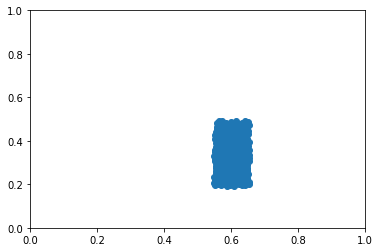

In [36]:
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(grand_truth_position[0,:,0], grand_truth_position[0,:,1])

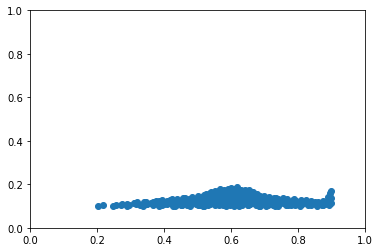

In [37]:
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(grand_truth_position[10,:,0], grand_truth_position[10,:,1])

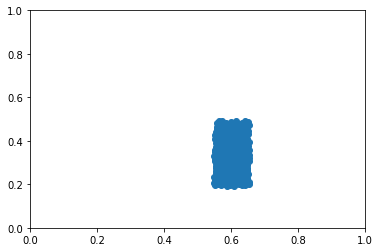

In [42]:
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.scatter(data.x[:,0], data.x[:,1])

In [ ]:
model.cpu()
model.eval()
from torch_geometric.data import Data
_, data = next(enumerate(test_gtrajs[0]))
for i in range(500):
    x = model(data.x, data.edge_index, data.edge_attr.unsqueeze(dim=0).t())
    x_next= (data.x[:,0:2]+dt*x).detach().numpy()
    vel = x.detach().numpy()
    node_feats = np.c_[x_next,vel,data.x.numpy()]
    node_feats = np.delete(node_feats, [-1,-2,4,5],1)
    edge_inds=radius_graph(torch.tensor(node_feats), r = r,loop = True)
    edge_weights = np.array([np.linalg.norm(node_feats[edg[0]][0:2]-node_feats[edg[1]][0:2]) for edg in edge_inds.T])
    data = Data(x = torch.tensor(node_feats), edge_index= torch.tensor(edge_inds),edge_attr=torch.tensor(edge_weights))
        
    if (i+1)%499 == 0:
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.scatter(data.x[:,0], data.x[:,1])


<ipython-input-127-e1f7257c3fee>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x = torch.tensor(node_feats), edge_index= torch.tensor(edge_inds),edge_attr=torch.tensor(edge_weights))


tensor([1.4373, 1.4380, 1.4367, 1.4268, 1.4250, 1.4301, 1.4326, 1.4380, 1.4337,
        1.4332, 1.4311, 1.4237, 1.4294, 1.4227, 1.4144, 1.4154, 1.4007, 1.4086,
        1.4064, 1.4379, 1.4300, 1.4325, 1.4235, 1.4214, 1.4319, 1.4181, 1.4119,
        1.3947, 1.3933, 1.4068, 1.4343, 1.4297, 1.4259, 1.4360, 1.4316, 1.4250,
        1.4175, 1.4117, 1.4136, 1.4044, 1.3933, 1.3898, 1.3788, 1.3859, 1.3842,
        1.3784, 1.3989, 1.4284, 1.4347, 1.4179, 1.4136, 1.4089, 1.4107, 1.4223,
        1.3930, 1.4012, 1.4225, 1.4127, 1.4178, 1.4012, 1.3924, 1.3932, 1.4042,
        1.3820, 1.3805, 1.3918, 1.3901, 1.4031, 1.4090, 1.3744, 1.3664, 1.3725,
        1.4225, 1.4077, 1.4142, 1.4132, 1.3743, 1.3707, 1.3665, 1.4189, 1.3991,
        1.4044, 1.4211, 1.3807, 1.3924, 1.4237, 1.4167, 1.4279, 1.4214, 1.3853,
        1.3936, 1.3883, 1.3958, 1.4038, 1.3720, 1.3796, 1.3742, 1.3873, 1.3759,
        1.3584, 1.3648, 1.3732, 1.4314, 1.4365, 1.4098, 1.4228, 1.4150, 1.3819,
        1.3737, 1.3814, 1.3639, 1.4120, 